In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.animation import FuncAnimation

In [2]:
from scipy.signal import savgol_filter


def compute_spread_len(ds, h_factor=1.05):
    mask = ds.h > (ds.attrs["hₛ"] * h_factor)
    return mask.sum("x") * ds.x.diff("x").median()


def compute_drop_velocity(ds, filter_winlen=51, filter_polyorder=3):
    c = ds.x[ds.h.argmax("x")].diff("t")
    c = c.where((c > 0) & (c < 20)).dropna("t").interp(t=ds.t)
    c = xr.DataArray(
        data=savgol_filter(c, filter_winlen, filter_polyorder),
        coords=c.coords,
        dims=c.dims,
    )
    return c

In [3]:
from pathlib import Path
from typing import Dict
from xarray import Dataset


datasets: Dict[str, Dataset] = {}
for ds in sorted(Path("../data/outputs/hs_effect_wreproj/").glob("*.nc")):
    ds = xr.open_dataset(ds).isel(y=0)
    ds["spread_len"] = compute_spread_len(ds)
    ds["drop_velocity"] = compute_drop_velocity(ds, filter_winlen=101)
    datasets[ds.attrs["hₛ"]] = ds

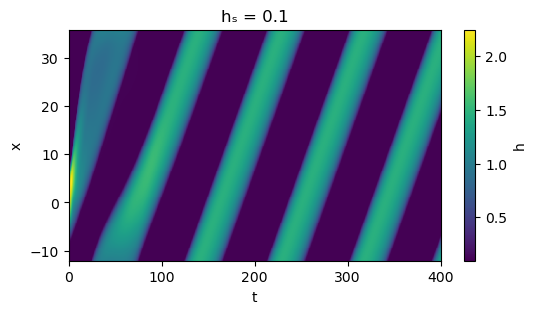

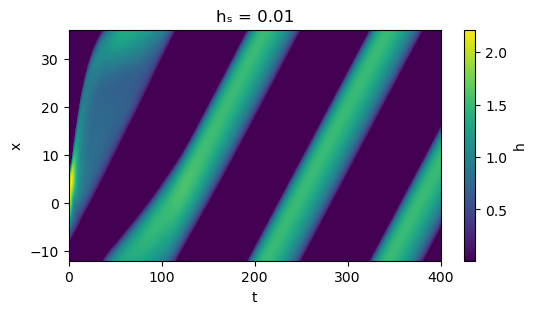

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
datasets[0.1].h.plot.imshow(ax=ax)
ax.set_title("hₛ = 0.1")
fig.savefig("../reports/figures/hs_param/x_t_h_hs_0.1.png", dpi=200)

fig, ax = plt.subplots(figsize=(6, 3))
datasets[0.01].h.plot.imshow(ax=ax)
ax.set_title("hₛ = 0.01")
fig.savefig("../reports/figures/hs_param/x_t_h_hs_0.01.png", dpi=200)

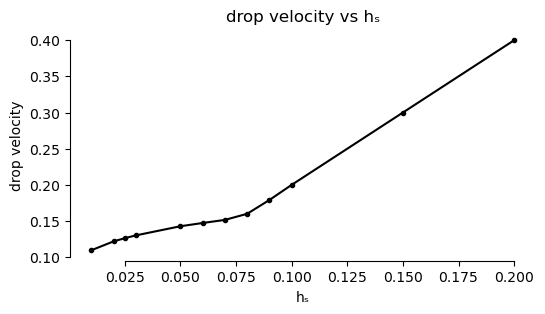

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(
    *zip(
        *[
            (hs, ds.drop_velocity.isel(t=slice(-500, None)).mean())
            for hs, ds in datasets.items()
        ]
    ),
    marker=".",
    color="k",
)
ax.set_xlabel("hₛ")
ax.set_ylabel("drop velocity")
ax.set_title("drop velocity vs hₛ")
sns.despine(trim=True)

fig.savefig("../reports/figures/hs_param/drop_velocity_vs_hs.png", dpi=100)
fig.savefig("../reports/figures/hs_param/drop_velocity_vs_hs.pdf", dpi=300)

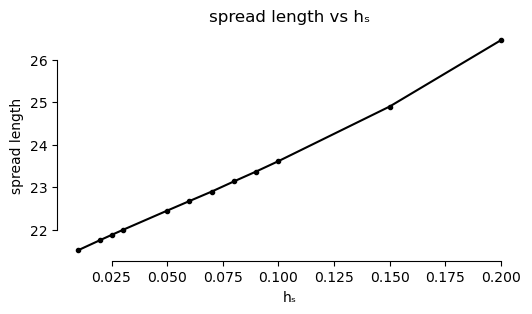

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(
    *zip(
        *[
            (hs, ds.spread_len.isel(t=slice(-500, None)).mean())
            for hs, ds in datasets.items()
        ]
    ),
    marker=".",
    color="k",
)

ax.set_xlabel("hₛ")
ax.set_ylabel("spread length")
ax.set_title("spread length vs hₛ")
sns.despine(trim=True)
fig.savefig("../reports/figures/hs_param/spread_len_vs_hs.png", dpi=100)
fig.savefig("../reports/figures/hs_param/spread_len_vs_hs.pdf", dpi=300)

In [40]:
# for hs in datasets:
#     ds = datasets[hs]

#     fig, ax = plt.subplots(figsize=(6, 4))

#     frame = ds.h.sel(t=0.0)
#     frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
#     ax.plot(ds.x, frame, color="k")
#     ax.set_title(f"t = {0.0:.2f}")
#     ax.set_xlabel("x")
#     ax.set_ylabel("h")
#     ymin, ymax = ax.get_ylim()
#     sns.despine(trim=True)
#     def animate(t):
#         ax.clear()
#         frame = ds.h.sel(t=t)
#         frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
#         ax.plot(ds.x, frame, color="k")
#         ax.set_title(f"t = {t:.2f}")
#         ax.set_xlabel("x")
#         ax.set_ylabel("h")
#         ax.set_ylim(ymin, ymax)
#         sns.despine(trim=True)
#         return ax

#     anim = FuncAnimation(fig, animate, frames=ds.t, interval=100)
#     anim.save(f"../reports/movies/hs_param/hs={hs:g}.mp4", writer="ffmpeg", fps=24)

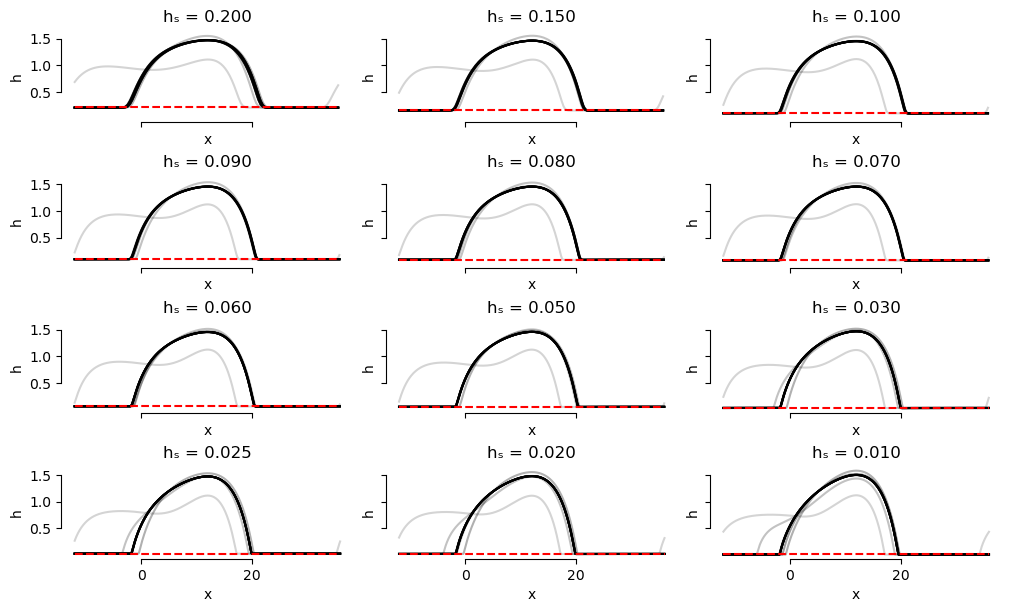

In [37]:
fig, axs = plt.subplots(4, 3, figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True)

for ds, ax in zip(reversed(datasets.values()), axs.flatten()):
    xmin, xmax = ds.x.min(), ds.x.max()
    n_traces = 10
    step = len(ds.t) // n_traces
    for i, t in enumerate(ds.t[::step]):
        if i == 0:
            continue
        frame = ds.h.sel(t=t)
        frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
        frame.plot(ax=ax, color="k", alpha=(i / n_traces) * (0.8 - 0.1) + 0.1)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    frame.plot(ax=ax, color="k")
    ax.hlines(ds.attrs["hₛ"] * 1.1, xmin, xmax, color="r", linestyle="--")
    ax.set_title(f"hₛ = {ds.attrs['hₛ']:.3f}")
    sns.despine(trim=True)
fig.savefig("../reports/figures/hs_param/traces_x_vs_h.pdf", dpi=300)
fig.savefig("../reports/figures/hs_param/traces_x_vs_h.png", dpi=100)

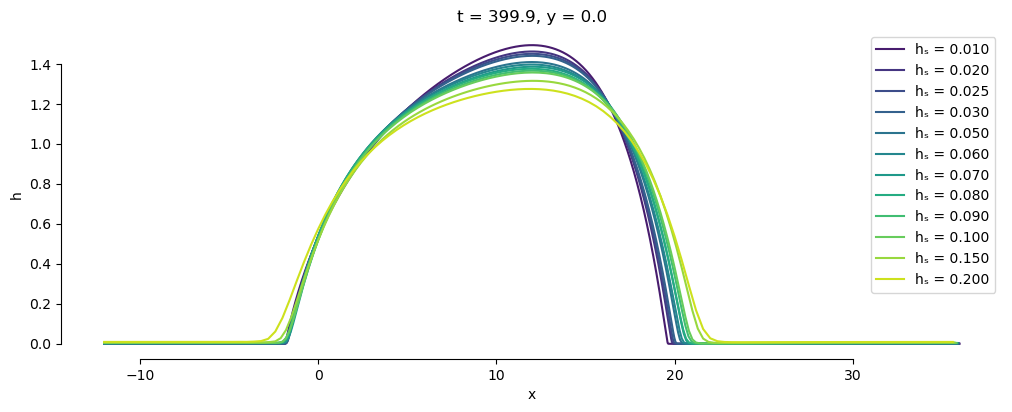

In [38]:
fig, ax = plt.subplots(figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

cycle1 = iter(sns.color_palette("viridis", n_colors=12).as_hex())
for ds in list(datasets.values()):
    color = next(cycle1)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x"))) - ds.attrs["hₛ"]
    frame.plot(ax=ax, color=color, label=f"hₛ = {ds.attrs['hₛ']:.3f}")
    sns.despine(trim=True)
ax.legend()
fig.savefig("../reports/figures/hs_param/x_vs_h.png", dpi=100)
fig.savefig("../reports/figures/hs_param/x_vs_h.pdf", dpi=300)

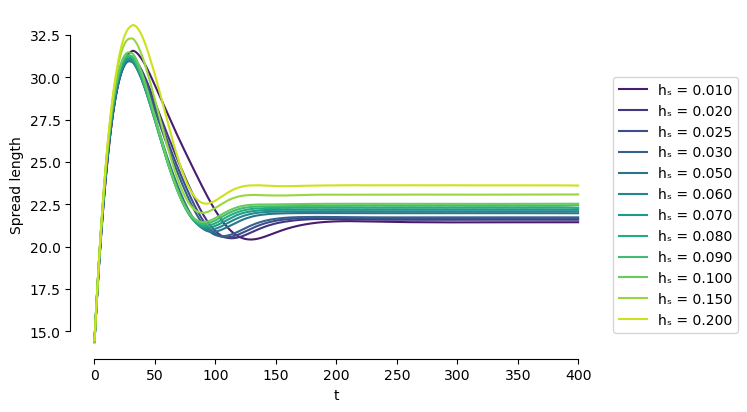

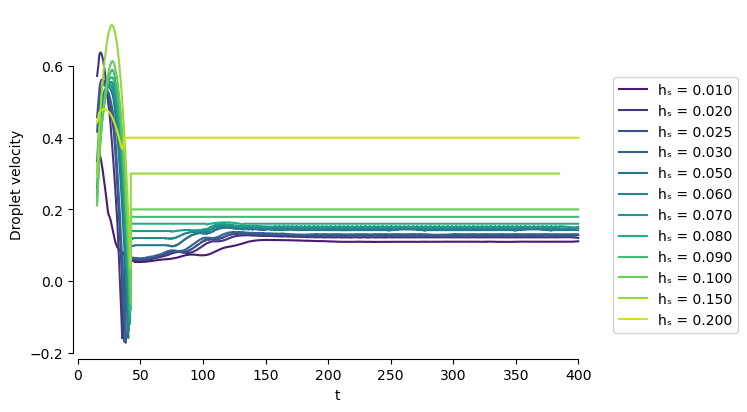

In [39]:
hss = sorted(datasets.keys())
fig, ax = plt.subplots(figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)
for hₛ, color in zip(hss, sns.color_palette("viridis", n_colors=len(hss)).as_hex()):
    spread_len = compute_spread_len(datasets[hs], h_factor=1.5)
    ax.plot(spread_len.t, savgol_filter(spread_len, 201, 3), color=color, label=f"hₛ = {hs:.3f}")
ax.set_xlabel("t")
ax.set_ylabel("Spread length")
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
sns.despine(trim=True)
fig.savefig("../reports/figures/hs_param/spread_len_vs_t.pdf", dpi=300)
fig.savefig("../reports/figures/hs_param/spread_len_vs_t.png", dpi=100)

fig, ax = plt.subplots(figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)
for hₛ, color in zip(hss, sns.color_palette("viridis", n_colors=12)):
    vel = datasets[hs].drop_velocity
    ax.plot(vel.t, vel, color=color, label=f"hₛ = {hₛ:.3f}")
ax.set_xlabel("t")
ax.set_ylabel("Droplet velocity")
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
sns.despine(trim=True)
fig.savefig("../reports/figures/hs_param/drop_vel_vs_t.pdf", dpi=300)
fig.savefig("../reports/figures/hs_param/drop_vel_vs_t.png", dpi=100)